# Практическое ДЗ 1. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [ ]:
%pip install -q moviepy --upgrade

In [1]:
import moviepy.editor as mpe

video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
video.fps

23.976023976023978

In [4]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


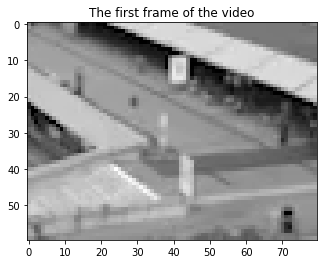

In [5]:
arr = video_to_array(video)

plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

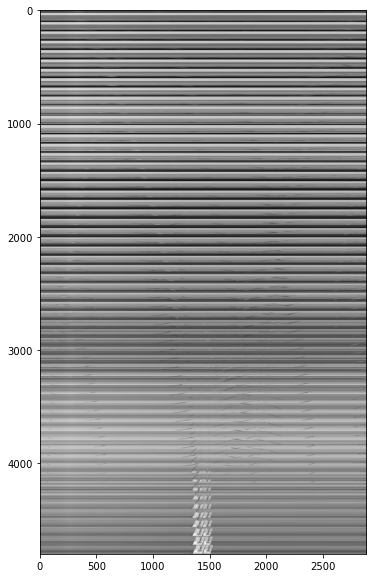

In [6]:
# np.set_printoptions(threshold=sys.maxsize)
nframes, size_w, size_h = arr.shape
M = arr.reshape(nframes, size_h * size_w).T
plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray')
plt.show()

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

(4800, 2883)


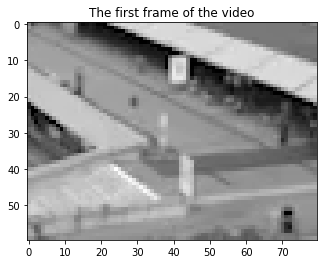

In [7]:
print(M.shape)
first_frame = M[:,0].reshape(size_w, size_h) # TO BE FILLED
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

In [8]:
# YOUR CODE GOES HERE
u, s, vh = np.linalg.svd(M, full_matrices=False)
print(u.shape, s.shape, vh.shape)

(4800, 2883) (2883,) (2883, 2883)


**Действительно, без логарифмической шкалы совсем непонятно, что происходит с сингулярными значениями**

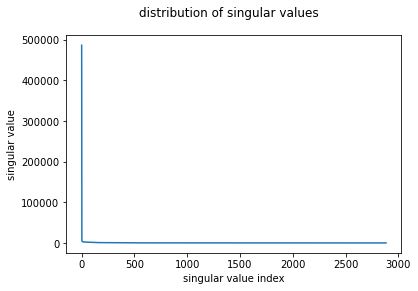

In [9]:
fig = plt.figure()
plt.plot(range(len(s)), s)
fig.suptitle('distribution of singular values')
plt.xlabel('singular value index')
plt.ylabel('singular value')
plt.show()

**Так лучше**

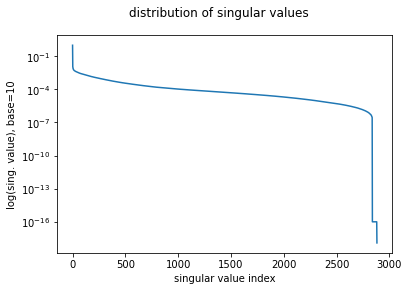

In [10]:
fig = plt.figure()
plt.semilogy(range(len(s)), s / s[0])
fig.suptitle('distribution of singular values')
plt.xlabel('singular value index')
plt.ylabel('log(sing. value), base=10')
plt.show()

***По поводу различия у сингулярных значений:***

**Фон на видео играет ключевую роль (не меняется цветовая грамма, он занимает очень большую часть каждого кадра и т. д.). Каждый кадр можно воспринимать как сумму матриц: одна задает фон, а другая - движущиеся объекты.
Первое сингуляное значение отвечает фону и так сильно больше остальных как раз потому, что общий вид картины (контраст, цветовая гамма, ...) не сильно меняется.
Несколько наименьших сигнулярных значений отвечают за шум - поэтому они так близки к нулю.**


3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в матричной 2-норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

**$M = USV^t \Longrightarrow \|M\|_F = \|S\|_F$**

In [11]:
def trunc_svd(M, r):
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    Ur, Sr, Vhr = U[:, :r], S[:r], Vh[:r, :]
    
    rel_eps = np.linalg.norm(S - np.pad(Sr, (0, S.shape[0]-r), 'constant', constant_values=0)) / np.linalg.norm(S)
    Mr = Ur @ np.diag(Sr) @ Vhr
    return Mr, rel_eps


4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [14]:
# YOUR CODE GOES HERE
M_svd, rel_eps = trunc_svd(M, 1)

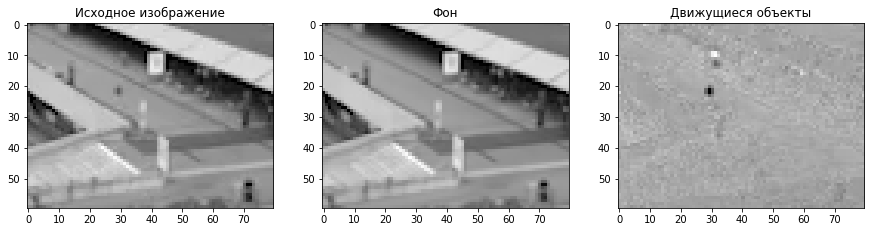

In [15]:
initial_first_frame = arr[0, :, :]
background = M_svd[:,0].reshape(size_w, size_h)
first_frame_objects = initial_first_frame - background

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(initial_first_frame, cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(background, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(first_frame_objects, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");



### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [16]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 100 x 178, 
number of frames: 3600


In [17]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = arr3.reshape(nframes, size_h * size_w).T # TO BE FILLED

image size: 100 x 178, 
number of frames: 3600


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

**$M*Omega = Y = QR = Q(Q^*M_3) = Q(WSV^*) = (QW)SV^*$**

In [18]:
def rand_svd(M, r, oversampling=10):
    Rand = np.random.randn(M.shape[1], r + oversampling)
    Y = M @ Rand
    Q, R = np.linalg.qr(Y)
    W, S, Vh = np.linalg.svd(Q.T @ M, full_matrices=False)
    QWr, Sr, Vhr = (Q @ W)[:, :r], S[:r], Vh[:r, :]
    M_rand = QWr @ np.diag(Sr) @ Vhr
    rel_eps = np.linalg.norm(M - M_rand) / np.linalg.norm(M)
    return M_rand, rel_eps

2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [19]:
# YOUR CODE GOES HERE
M_rand, rel_eps = rand_svd(M3, 1)
print(rel_eps)

0.04864345761905818


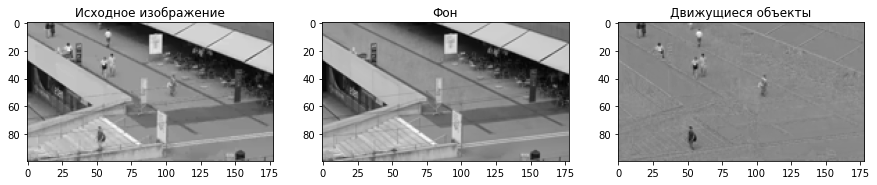

In [20]:
initial_first_frame = arr3[0, :, :]
background = M_rand[:,0].reshape(size_w, size_h)
first_frame_objects = initial_first_frame - background

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(initial_first_frame, cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(background, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(first_frame_objects, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");


3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

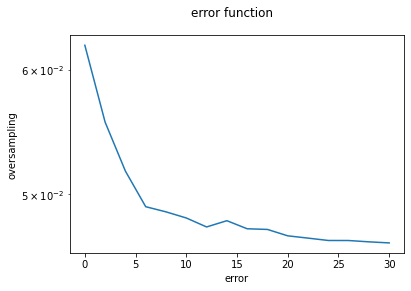

In [21]:
# YOUR CODE GOES HERE

P = np.arange(0, 31, 2)
REL_EPS = np.zeros(16)
for _ in range(10):
    for i in range(16):
        _, rel_eps = rand_svd(M3, 2, oversampling=P[i])
        REL_EPS[i] += rel_eps

REL_EPS /= 10

fig = plt.figure()
plt.semilogy(P, REL_EPS)
fig.suptitle('error function')
plt.xlabel('error')
plt.ylabel('oversampling')
plt.show()
    

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти. 

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [22]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [23]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [24]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

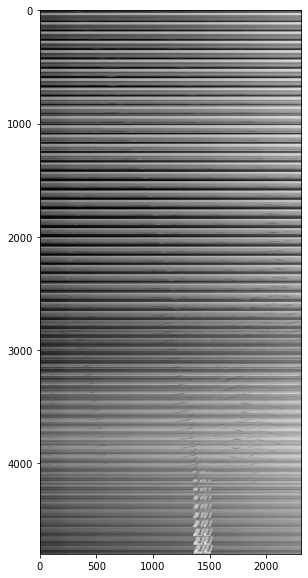

In [25]:
nframes2, size_w, size_h = arr2.shape
M2 = arr2.reshape(nframes2, size_h * size_w).T # YOUR CODE GOES HERE

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [26]:
%timeit M2_svd, rel_eps_trunc2 = trunc_svd(M2, 2) # переменное освещение

8.18 s ± 584 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit M2_rand, rel_eps_rand2 = rand_svd(M2, 2) # переменное освещение

81.8 ms ± 5.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Рандомизированный алгоритм работает примерно в 6 раз быстрее, чем библиотечные функции**

3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [28]:
M3_svd, rel_eps_svd3 = trunc_svd(M3, 2)  # постоянное освещение (второе видео с лучшим расширением)
M3_rand, rel_eps_rand3 = rand_svd(M3, 2) # постоянное освещение (второе видео с лучшим расширением)
M2_svd, rel_eps_trunc2 = trunc_svd(M2, 2) # переменное освещение
M2_rand, rel_eps_rand2 = rand_svd(M2, 2) # переменное освещение

In [29]:
print(f"библиотечная функция: переменное освещение - {rel_eps_trunc2}, постоянное освещение - {rel_eps_svd3}")
print(f"рандомизированный алгоритм: переменное освещение - {rel_eps_rand2}, постоянное освещение - {rel_eps_rand3}")

библиотечная функция: переменное освещение - 0.06063233098450473, постоянное освещение - 0.04555364920579864
рандомизированный алгоритм: переменное освещение - 0.06415472520116236, постоянное освещение - 0.048686429834546414


**Обоими способами приближение ранга 2 работает лучше для видео с постоянным освещением. Это можно объяснить тем, что
при постоянном освещении первые 2 сингулярных значения несут больше информации о видео, чем при переменном. (То есть числа в первом случае больше).**

**При этом честное SVD показывает большую вычислительную точность и дает наилучшее приближение.**

4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [30]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = np.array([(M.T)[i, :].reshape(size_w, size_h) for i in range(nframes)]) # YOUR CODE GOES HERE
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [31]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

In [32]:
nframe3, size_w3, size_h3 = arr3.shape
fps3 = video3.fps
video3_svd = M_to_video(M3_svd - M3, fps3, size_w3, size_h3)
video3_svd.ipython_display(width=300, maxduration=250, fps=fps3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным. 

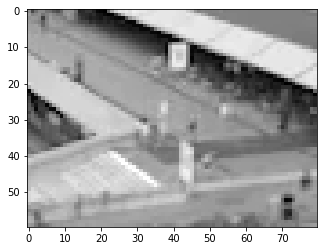

In [33]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [34]:
# YOUR CODE GOES HERE (duplicate code from trunc_SVD)
U, S, VT = np.linalg.svd(M2, full_matrices=False)
U_2, S_2, VT_2 = U[:, :2], S[:2], VT[:2, :]


$Im(M_2) = Im(U_r)$, где $U_r$ - из сингулярного разложения. $P = U_rU_r^*$ - ортопроектор на $Im(M_2)$

In [35]:
def project_new_frames(U, S, VT, new_frames):
    return U @ U.T @ new_frames

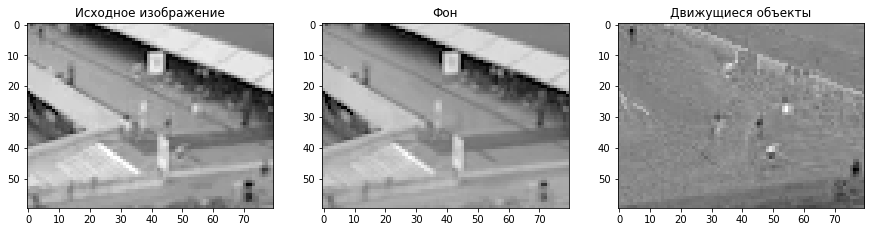

In [36]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)
background = new_frame_proj.reshape(size_w, size_h)
objects = new_frame.reshape(size_w, size_h) - background

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(background, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(objects, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [37]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = remaining.reshape(remaining_nframes, size_h * size_w).T # YOUR CODE GOES HERE
M_full = np.concatenate((M2, M_remaining), axis = 1) # YOUR CODE GOES HERE


In [38]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)
video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [39]:
r = 2
oversampling = 20

# YOUR CODE GOES HERE (duplicate code from rand_SVD)

Rand = np.random.randn(M2.shape[1], r + oversampling)
Y = M2 @ Rand
Q, R = np.linalg.qr(Y)
W, S, Vh = np.linalg.svd(Q.T @ M2, full_matrices=False)
U_2_rand, S_2_rand, VT_2_rand = (Q @ W)[:, :r], S[:r], Vh[:r, :]


In [40]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad 
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [41]:
M_true, rel_eps_M_true = trunc_svd(M_full, 2)
video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [42]:
# YOUR CODE GOES HERE

# ошибка M_proj относительно M_true
rel_eps_proj = np.linalg.norm(M_true - M_proj) / np.linalg.norm(M_true)

# ошибка M_proj_rand относительно M_true
rel_eps_proj_rand = np.linalg.norm(M_true - M_proj_rand) / np.linalg.norm(M_true)

print(f'ошибка M_proj относительно M_true {rel_eps_proj}')
print(f'ошибка M_proj_rand относительно M_true {rel_eps_proj_rand}')


ошибка M_proj относительно M_true 0.02000144506567803
ошибка M_proj_rand относительно M_true 0.02439073948710674


In [43]:
# ошибка M_true относительно M_full
print(f'ошибка M_true относительно M_full {rel_eps_M_true}')

# ошибка M_proj относительно M_full
rel_eps_proj_full = np.linalg.norm(M_full - M_proj) / np.linalg.norm(M_full)
print(f'ошибка M_proj относительно M_full {rel_eps_proj_full}')

# ошибка M_proj_rand относительно M_full
rel_eps_proj_rand_full = np.linalg.norm(M_full - M_proj_rand) / np.linalg.norm(M_full)
print(f'ошибка M_proj_rand относительно M_full {rel_eps_proj_rand_full}')

ошибка M_true относительно M_full 0.05459538505504901
ошибка M_proj относительно M_full 0.05740339325789152
ошибка M_proj_rand относительно M_full 0.059110116689756666


**Выводы:**
**Сложно сравнивать качество видео на глаз, так как в принципе кроме черного экрана изредка появляются светлые пятна. Но заметно, что у наилучшего приближения, конечно, светлые пятна более четкие, что говорит о лучшем качестве. А у приближений проекциями есть светлые пятна, которые соответствуют части фона, что не есть хорошо. Что касается относительной точности приближений, ортопроекция с помощью библиотечного SVD выигрывает у рандомизированной проекции, а в целом честное SVD выигрывает у ортопроекций - теперь мы убедились в этом наглядно, а не теоретически (как на лекции).**


### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [44]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

--2023-02-11 17:08:09--  https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3105 (3,0K) [text/plain]
Сохранение в: «r_pca.py.3»

r_pca.py.3          100%[===================>]   3,03K  --.-KB/s    за 0s      

2023-02-11 17:08:09 (12,7 MB/s) - «r_pca.py.3» сохранён [3105/3105]



Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

In [45]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)


iteration: 1, error: 10.068199117428184
iteration: 100, error: 0.700442397676858
iteration: 200, error: 0.42632079958289715
iteration: 300, error: 0.2861554334228383
iteration: 400, error: 0.1976376299223307
iteration: 500, error: 0.1491945130601841
iteration: 600, error: 0.11977760984761211
iteration: 700, error: 0.10258379675968134
iteration: 800, error: 0.08740324618531815
iteration: 900, error: 0.07772202053799196
iteration: 1000, error: 0.06319242183802795
iteration: 1100, error: 0.05727756160981617
iteration: 1200, error: 0.043619632074256905
iteration: 1300, error: 0.042779182960679764
iteration: 1400, error: 0.028313363610494014
iteration: 1500, error: 0.02821559205466559
iteration: 1546, error: 0.017703452810724087


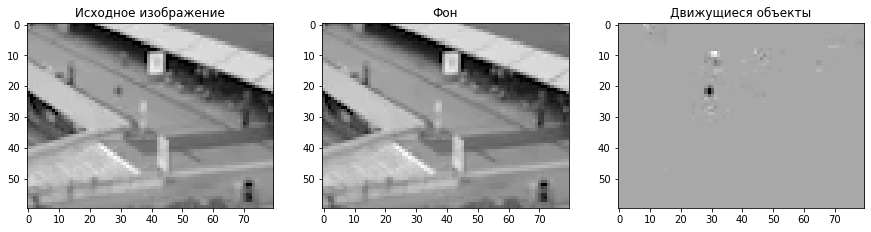

In [46]:
initial_first_frame = Mt[:, 0].reshape(size_w, size_h)
background = L[:, 0].reshape(size_w, size_h)
objects = S[:, 0].reshape(size_w, size_h)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(initial_first_frame, cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(background, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(objects, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [47]:
video_rpca = M_to_video(S, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

In [48]:
arr = video_to_array(video)
nframes, size_w, size_h = arr.shape
M = arr.reshape(nframes, size_h * size_w).T


image size: 60 x 80, 
number of frames: 2883


In [50]:
def rand_subspace_iteration_Q(M, r, q=20, oversampling = 10):
    l = r + oversampling
    m, n = M.shape
    Rand = np.random.randn(n, l)
    Y = M @ Rand
    Q, R = np.linalg.qr(Y)
    
    for i in range(q):
        Yj = M.T @ Q
        Qj, _ = np.linalg.qr(Yj)
        Yi = M @ Qj
        Q, _ = np.linalg.qr(Yi)
    
    return Q

In [51]:
def rand_subspace_iteration_svd(M, r, q=20, oversampling=10):
    Q = rand_subspace_iteration_Q(M, r, q, oversampling)
    W, S, Vh = np.linalg.svd(Q.T @ M, full_matrices=False)
    QW, S, Vh = (Q @ W)[:, :r], S[:r], Vh[:r, :]
    M_adaptive_rand = QW @ np.diag(S) @ Vh
    return M_adaptive_rand

In [52]:
def get_norm(M, r, q, step):
    M_true, _ = trunc_svd(M, r)
    norms = []
    for i in range(1, q, step):
        M_new = rand_subspace_iteration_svd(M, r, i)
        norms.append(np.linalg.norm(M_true - M_new))
    return norms

**Ранг 5**

In [53]:
M5 = rand_subspace_iteration_svd(M, 5)
video_rpca = M_to_video(M5, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**Ранг 20**

In [55]:
M20 = rand_subspace_iteration_svd(M, 20)

video_rpca = M_to_video(M20, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**Ранг 50**

In [56]:
M50 = rand_subspace_iteration_svd(M, 50)

video_rpca = M_to_video(M50, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**График зависимости ошибки при рангах 5, 20, 50 от количества итераций**

In [57]:
norms5 = get_norm(M, 5, q=100, step=2)
norms20 = get_norm(M, 20, q=100, step=2)
norms50 = get_norm(M, 50, q=100, step=2)

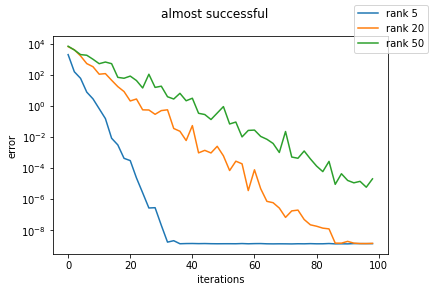

In [58]:
q = np.arange(0, 100, 2)
fig = plt.figure()
plt.semilogy(q, norms5, q, norms20, q, norms50)
fig.suptitle('almost successful')
fig.legend(['rank 5', 'rank 20', 'rank 50'], loc='upper right')
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()